# Pipe Flow Heat Transport PDE Simulations with Pyomo

Solving the heat transport for incompressible fluid flow in a horizontal pipe:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyomo as pyo

In [2]:
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

## Single Temperature Flow Model Simulation

**Solar collector section ($0 < x ≤ L$):**
$$\frac{\partial T}{\partial t} + v(t) \frac{\partial T}{\partial x} = \alpha \frac{\partial^2 T}{\partial x^2} + \frac{q(t)}{\rho c_p} - \frac{4 h(T - T_{amb})}{D \rho c_p}$$

**Insulated pipe extension at outlet ($L < x ≤ L_{extended}$):**
$$\frac{\partial T}{\partial t} + v(t) \frac{\partial T}{\partial x} = \alpha \frac{\partial^2 T}{\partial x^2}$$

Where:
- $T(x,t)$ : temperature at position x and time t [K]
- $v(t)$ : time-varying fluid velocity [m/s]
- $\alpha$ : thermal diffusivity [m²/s]
- $q(t)$ : time-varying volumetric heat input rate [W/m³]
- $c_p$ : specific heat capacity [J/kg·K]
- $h$ : convective heat transfer coefficient [W/m²·K]
- $D$ : pipe inner diameter [m]
- $T_{amb}$ : ambient temperature [K]

In [3]:
from solar_collector.solar_collector_dae_pyo import (
    ZERO_C,
    PIPE_DIAMETER,
    COLLECTOR_LENGTH,
    THERMAL_DIFFUSIVITY,
    create_pipe_flow_model,
    add_pde_constraints,
    solve_model,
    plot_results,
    print_temp_profiles,
)

model_name = "oil_temp"

In [4]:
# Calculate Damköhler Number
L = COLLECTOR_LENGTH  # m
r = PIPE_DIAMETER / 2.0  # m
thermal_diffusivity = 2e-6  # m^2/s
velocity = 0.5  # m/s
Da = (r**2 / thermal_diffusivity) / (L / velocity)

# Use multi-region models when Da > 2
Da

3.0625000000000004

Creating pipe flow heat transport model...
Using Dittus-Boelter correlation for h:
  Initial velocity: 0.500 m/s
  Reynolds number: 2800
  Prandtl number: 166.7
  Nusselt number: 4.4
  Heat transfer coefficient: 7.5 W/m²·K
Adding PDE constraints...
Solving the discretized PDE...
Discretized with 111 x points and 51 t points
Solving with IPOPT...
Ipopt 3.14.19: max_iter=1000
tol=1e-06
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    77324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of n

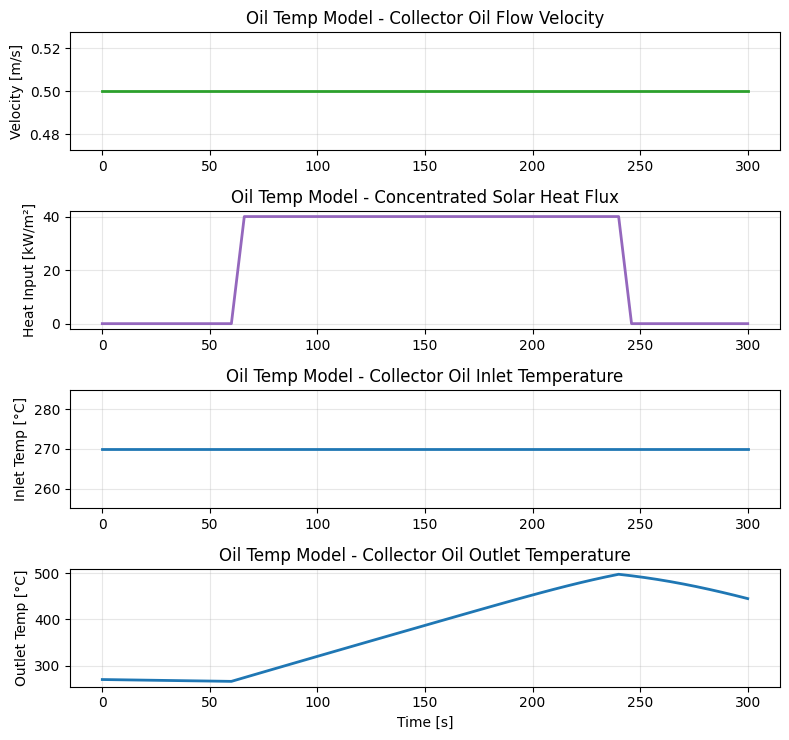

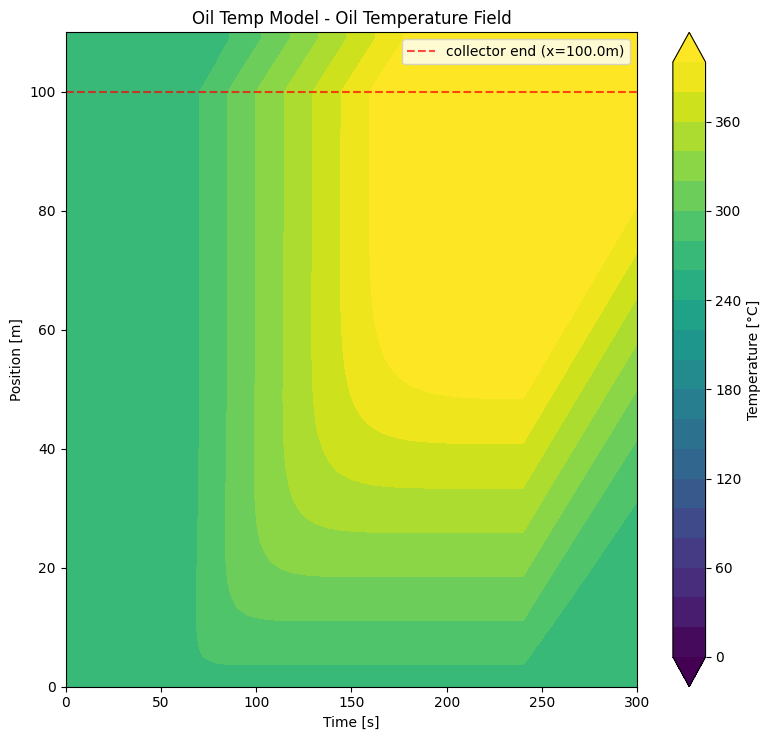


TEMPERATURE PROFILE ANALYSIS

Temperature profiles at different times:
Time [s] Inlet [K]  Outlet [K] End [K]    ΔT [K]    
--------------------------------------------------
0.00     543.1      543.1      543.1      0.0       
60.00    543.1      539.2      540.4      -2.8      
120.00   543.1      620.2      596.1      52.9      
180.00   543.1      700.3      676.4      133.2     
240.00   543.1      771.0      752.0      208.8     
300.00   543.1      718.3      737.6      194.5     

Temperature evolution at different positions:
Position [m] Initial [K]  Final [K]    Change [K]  
--------------------------------------------------
0.00         543.1        543.1        0.0         
20.00        543.1        542.6        -0.5        
30.00        543.1        551.4        8.2         
60.00        543.1        619.1        76.0        
80.00        543.1        671.0        127.9       
100.00       543.1        718.3        175.2       
110.00       543.1        737.6        194.5

In [5]:
# Create and solve the model
print("Creating pipe flow heat transport model...")
model = create_pipe_flow_model(t_final=60.0 * 5)  # Simulate for 5 minutes

print("Adding PDE constraints...")
model = add_pde_constraints(model)

print("Solving the discretized PDE...")
results = solve_model(model, n_x=110, n_t=50, tol=1e-6)

print(f"Solver status: {results.solver.status}")
print(f"Termination condition: {results.solver.termination_condition}")

if results.solver.termination_condition in ["optimal", "locallyOptimal"]:
    if results.solver.termination_condition == "locallyOptimal":
        print("WARNING: Solution found is only locally optimal.")
    print("Plotting results...")
    t_eval = ([0.0, 60.0, 120.0, 180.0, 240.0, 300.0],)
    x_eval = [0.0, 20.0, 30.0, 60.0, 80.0, 100.0, 110.0]
    fig1, fig2 = plot_results(model, t_eval=t_eval, x_eval=x_eval)
    fig1.tight_layout()
    filename = f"model_{model_name}_tsplots.png"
    fig1.savefig(os.path.join(plot_dir, filename), dpi=150)
    fig2.tight_layout()
    filename = f"model_{model_name}_oil_temp_field.png"
    fig2.savefig(os.path.join(plot_dir, filename), dpi=150)
    plt.show()
    print_temp_profiles(model, t_eval=t_eval, x_eval=x_eval)
else:
    print("Solution not optimal. Check model formulation.")
    print(f"Solver message: {results.solver.message}")

### Inspect Solution

In [6]:
T = pd.Series(model.T.extract_values())
T.index.names = ["t", "x"]
T = T.unstack()
T.shape

(51, 111)

## Flow and Pipe Wall Temperature Model Simulation

**Two-Temperature Model with Fluid and Pipe Wall:**

This model considers separate temperatures for the fluid ($T_f$) and pipe wall ($T_p$) with heat transfer between them.

**Fluid temperature equation:**
$$\rho_f c_{p,f} \frac{\partial T_f}{\partial t} + \rho_f c_{p,f} v(t) \frac{\partial T_f}{\partial x} = \rho_f c_{p,f} \alpha_f \frac{\partial^2 T_f}{\partial x^2} + \frac{4 h_{int}(T_p - T_f)}{D}$$

**Pipe wall temperature equation:**

*Solar collector section ($0 < x ≤ L$):*
$$\rho_p c_{p,p} \frac{\partial T_p}{\partial t} = \rho_p c_{p,p} \alpha_p \frac{\partial^2 T_p}{\partial x^2} + \frac{4 q(t) (D + 2d)}{(D + 2d)^2 - D^2} - \frac{4 h_{int}(T_p - T_f)}{D} - \frac{4 h_{ext} (D + 2d) (T_p - T_{amb})}{(D + 2d)^2 - D^2}$$

*Insulated pipe extension ($L < x ≤ L_{extended}$):*
$$\rho_p c_{p,p} \frac{\partial T_p}{\partial t} = \rho_p c_{p,p} \alpha_p \frac{\partial^2 T_p}{\partial x^2} - \frac{4 h_{int}(T_p - T_f)}{D} - \frac{4 h_{ext} (D + 2d) (T_p - T_{amb})}{(D + 2d)^2 - D^2}$$

Where:
- $T_f(x,t)$ : fluid temperature [K]
- $T_p(x,t)$ : pipe wall temperature [K]
- $\rho_f, \rho_p$ : fluid and pipe wall densities [kg/m³]
- $c_{p,f}, c_{p,p}$ : specific heat capacities [J/kg·K]
- $\alpha_f = k_f/(\rho_f c_{p,f})$ : fluid thermal diffusivity [m²/s]
- $\alpha_p = k_p/(\rho_p c_{p,p})$ : pipe wall thermal diffusivity [m²/s]
- $h_{int}$ : internal heat transfer coefficient (wall to fluid) [W/m²·K]
- $h_{ext}$ : external heat transfer coefficient (wall to ambient) [W/m²·K]
- $D$ : pipe inner diameter [m]
- $d$ : pipe wall thickness [m]
- $q(t)$ : time-varying heat flux input [W/m²]

In [7]:
from solar_collector.solar_collector_dae_pyo_two_temp import (
    ZERO_C,
    create_pipe_flow_model,
    add_pde_constraints,
    solve_model,
    plot_results,
    print_temp_profiles,
)

model_name = "oil_wall_temp"

Creating pipe flow heat transport model...
Using Dittus-Boelter correlation for h_int:
  Initial velocity: 0.500 m/s
  Reynolds number: 2800
  Prandtl number: 166.7
  Nusselt number: 4.4
  Heat transfer coefficient: 7.5 W/m²·K
Adding PDE constraints...
Solving the discretized PDE...
Discretized with 111 x points and 51 t points
Solving with IPOPT...
Ipopt 3.14.19: max_iter=1000
tol=1e-06
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   161298
Number of nonzeros in inequality constraint Jacobian.:        0
Number 

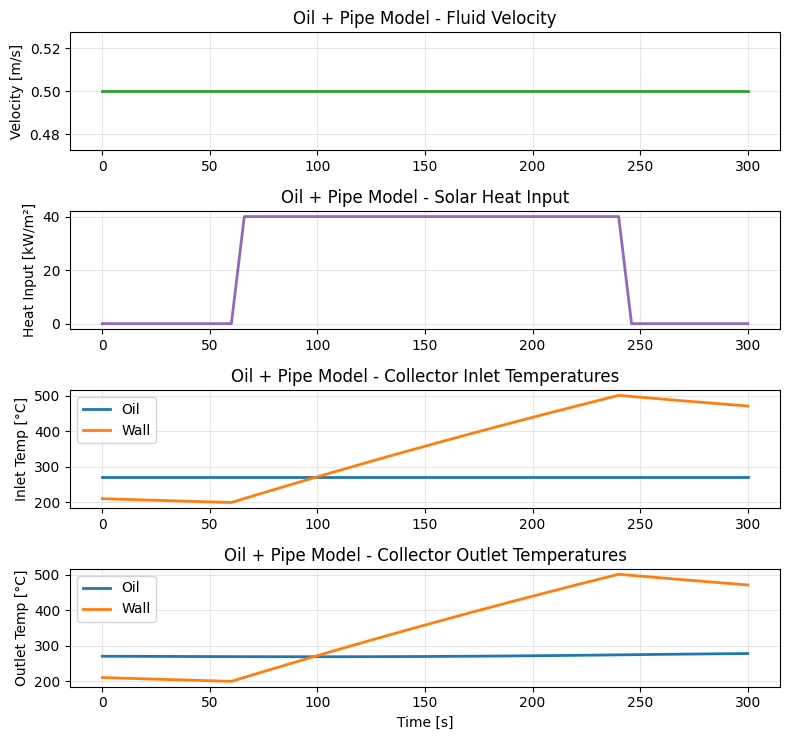

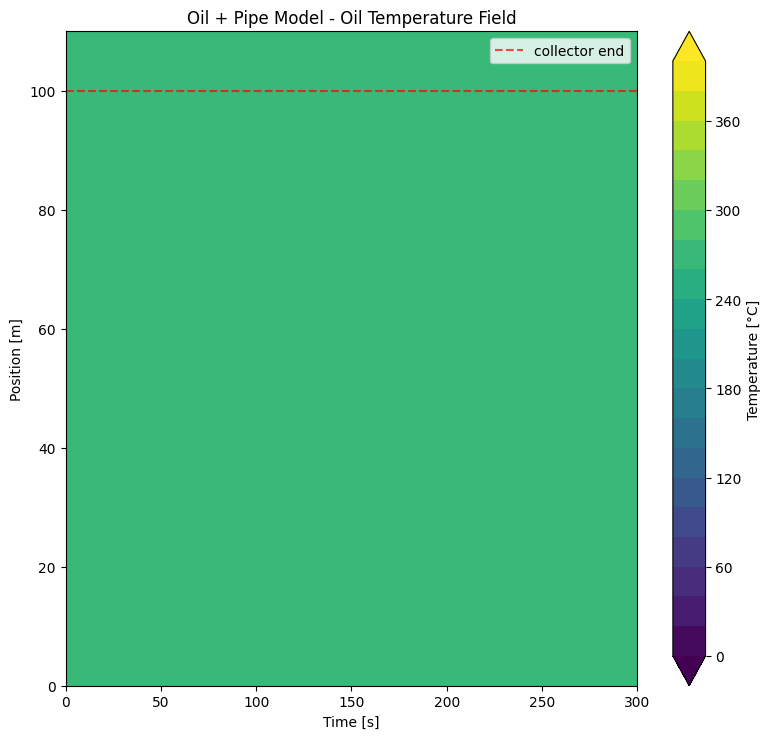

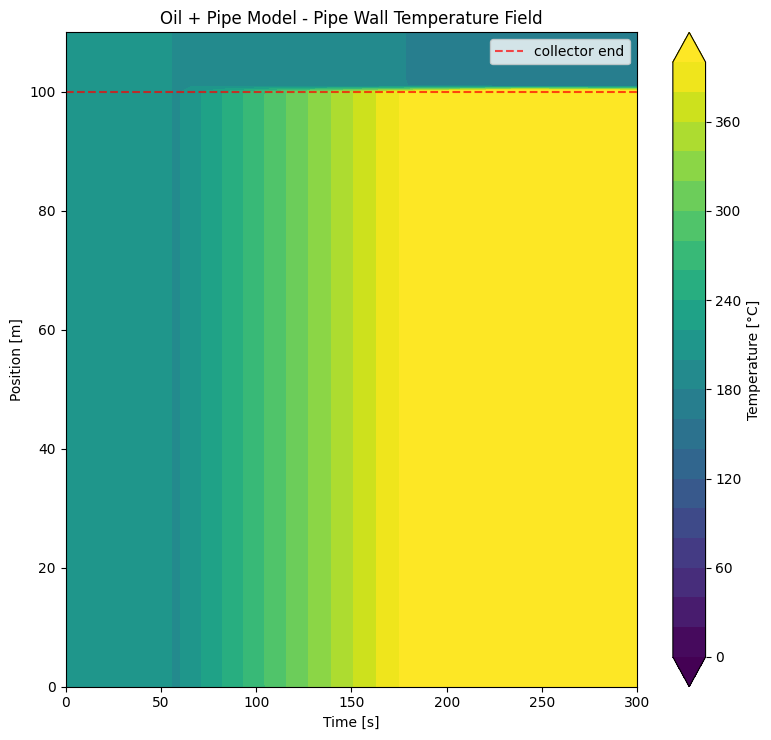


TWO-TEMPERATURE MODEL ANALYSIS

Fluid and pipe wall temperature profiles at different times:
Time [s]  T_f Inlet [K] T_f End [K]  T_p End [K]  ΔT_f [K]    T_p-T_f [K] 
-------------------------------------------------------------------------------
0.00      543.1         543.1        483.1        0.0         -60.0       
60.00     543.1         542.1        472.4        -1.0        -69.7       
120.00    543.1         541.9        580.0        -1.2        38.0        
180.00    543.1         543.6        680.4        0.4         136.8       
240.00    543.1         547.1        774.1        3.9         227.0       
300.00    543.1         550.8        744.0        7.6         193.2       

Fluid temperature evolution at different positions:
Position [m] Initial [K]  Final [K]    Change [K]  
------------------------------------------------
0.00         543.1        543.1        0.0         
20.00        543.1        545.4        2.2         
30.00        543.1        546.5        3.4 

In [8]:
# Create and solve the model
print("Creating pipe flow heat transport model...")
model = create_pipe_flow_model(t_final=60.0 * 5)  # Simulate for 5 minutes

print("Adding PDE constraints...")
model = add_pde_constraints(model)

print("Solving the discretized PDE...")
results = solve_model(model, n_x=110, n_t=50, tol=1e-6)

print(f"Solver status: {results.solver.status}")
print(f"Termination condition: {results.solver.termination_condition}")

if results.solver.termination_condition in ["optimal", "locallyOptimal"]:
    if results.solver.termination_condition == "locallyOptimal":
        print("WARNING: Solution found is only locally optimal.")
    print("Plotting results...")
    t_eval = ([0.0, 60.0, 120.0, 180.0, 240.0, 300.0],)
    x_eval = [0.0, 20.0, 30.0, 60.0, 80.0, 100.0, 110.0]
    fig1, fig2, fig3 = plot_results(model, t_eval=t_eval, x_eval=x_eval)
    fig1.tight_layout()
    filename = f"model_{model_name}_tsplots.png"
    fig1.savefig(os.path.join(plot_dir, filename), dpi=150)
    fig2.tight_layout()
    filename = f"model_{model_name}_oil_temp_field.png"
    fig2.savefig(os.path.join(plot_dir, filename), dpi=150)
    fig3.tight_layout()
    filename = f"model_{model_name}_wall_temp_field.png"
    fig3.savefig(os.path.join(plot_dir, filename), dpi=150)
    plt.show()
    print_temp_profiles(model, t_eval=t_eval, x_eval=x_eval)
else:
    print("Solution not optimal. Check model formulation.")
    print(f"Solver message: {results.solver.message}")